In [1]:
# 10/14/2020
# This notebook trains a CFL model with the visual bars dataset
# and compares the resulting observational partition with ground truth.

In [1]:
# imports
import generate_visual_bars_data as vbd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import sys
from time import sleep
import numpy as np

# cfl imports
sys.path.insert(1, '../../cfl')
from cfl.cluster_methods import kmeans
from cfl.density_estimation_methods import chalupkaCDE
import cfl.core_cfl_objects.two_step_cfl as tscfl
from cfl.util.data_processing import one_hot_encode

In [2]:
# generate data

n_samples = 10000
noise_lvl = 0
im_shape = (10, 10)
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))
sleep(1)
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl)

x = vb_data.getImages()
y = vb_data.getTarget()
 
x = np.expand_dims(x, -1)
y = one_hot_encode(y, unique_labels=[0,1])

# train test split
Xtr, Xts, Ytr, Yts = train_test_split(x, y, test_size=1500)

Generating a visual bars dataset with 10000 samples at noise level 0
100%|██████████| 10000/10000 [00:00<00:00, 11467.50it/s]


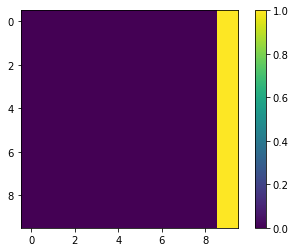

xshapes:  ((8500, 10, 10, 1), (1500, 10, 10, 1))
yshapes:  ((8500, 2), (1500, 2))


In [7]:
# plot an example image

plt.imshow(Xtr[1])
plt.colorbar()
plt.show()

print('xshapes: ', (Xtr.shape, Xts.shape))
print('yshapes: ', (Ytr.shape, Yts.shape))

In [8]:
# parameters for CDE 
lr = 1e-4 # this was 1e-3 in Chalupka's code
optimizer_Adam = tf.keras.optimizers.Adam(lr=lr)
condExp_params = {  'batch_size': 32, # this was 10 in Chalupka's code
                    'lr': lr, 
                    'optimizer': optimizer_Adam, 
                    'n_epochs': 30, 
                 }
data_info = {'X_dims': x.shape, 'Y_dims': y.shape} 

# generate CDE object
condExp_object = chalupkaCDE.ChalupkaCDE(data_info, condExp_params, True)

In [9]:
# generate clusterer 
cluster_params = {'n_Xclusters':4, 'n_Yclusters':2}
cluster_object = kmeans.KMeans(cluster_params)

In [10]:
# put into a cfl core object 
cfl_object = tscfl.Two_Step_CFL_Core(condExp_object, cluster_object)

Train on 8500 samples, validate on 1500 samples
Epoch 1/30
8500/8500 [==============================] - 2s 250us/sample - loss: 0.2199 - val_loss: 0.2011
Epoch 2/30
8500/8500 [==============================] - 1s 123us/sample - loss: 0.1958 - val_loss: 0.1888
Epoch 3/30
8500/8500 [==============================] - 1s 131us/sample - loss: 0.1839 - val_loss: 0.1768
Epoch 4/30
8500/8500 [==============================] - 1s 156us/sample - loss: 0.1718 - val_loss: 0.1650
Epoch 5/30
8500/8500 [==============================] - 1s 147us/sample - loss: 0.1617 - val_loss: 0.1558
Epoch 6/30
8500/8500 [==============================] - 1s 152us/sample - loss: 0.1540 - val_loss: 0.1488
Epoch 7/30
8500/8500 [==============================] - 2s 180us/sample - loss: 0.1483 - val_loss: 0.1446
Epoch 8/30
8500/8500 [==============================] - 1s 171us/sample - loss: 0.1446 - val_loss: 0.1414
Epoch 9/30
8500/8500 [==============================] - 1s 136us/sample - loss: 0.1422 - val_loss: 0.139

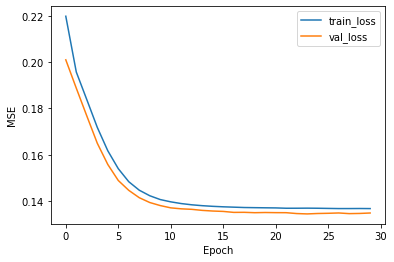

100%|██████████| 8500/8500 [00:11<00:00, 717.97it/s]


In [11]:
x_lbls_train, y_lbls_train, train_losses, test_losses, = cfl_object.train(x, y, standardize=False)


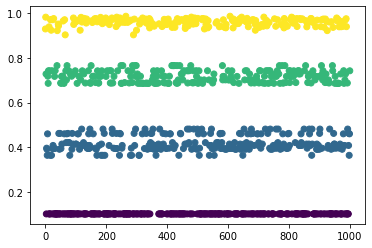

Average prediction for x-class 0: 0.10
Average prediction for x-class 1: 0.42
Average prediction for x-class 2: 0.72
Average prediction for x-class 3: 0.96


In [12]:
# before clustering, we can look at the distribution of CDE outputs
pyx = cfl_object.CDE_model.predict(x)
truth = vb_data.getGroundTruth()
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)
plt.scatter(range(1000), pyx[plot_idx,1], c=truth[plot_idx])
plt.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i,1])))

In [13]:
# generate observational partition on all data
x_lbls_all, y_lbls_all = cfl_object.predict(x, y)

# rand_score
print()
print('Rand score: ', adjusted_rand_score(truth, x_lbls_all))

100%|██████████| 10000/10000 [00:18<00:00, 546.45it/s]Rand score:  1.0



In [15]:
# calculate comparison with ground truth by hand
print(x_lbls_all[:20])
print(truth[:20])

[1 3 1 0 2 0 0 0 2 3 1 0 1 0 0 1 0 3 2 0]
[2 3 2 1 0 1 1 1 0 3 2 1 2 1 1 2 1 3 0 1]


In [19]:
accuracy = 0
for i in range(len(x_lbls_all)):
    if (x_lbls_all[i]==0) & (truth[i]==1):
        accuracy +=1
    elif(x_lbls_all[i]==1) & (truth[i]==2):
        accuracy +=1
    elif(x_lbls_all[i]==2) & (truth[i]==0):
        accuracy +=1
    elif(x_lbls_all[i]==3) & (truth[i]==3):
        accuracy +=1
        
print("Accuracy: ", accuracy/len(truth))

Accuracy:  1.0
